In [ ]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score, \
    accuracy_score

import re
from typing import List, Tuple

import pandas as pd


def is_contained(inner_start, inner_end, outer_start, outer_end):
    return (
        outer_start <= inner_start <= outer_end
        and outer_start <= inner_end <= outer_end
        and (inner_start, inner_end) != (outer_start, outer_end)
    )


def find_all_occurrences_indices(
    sentence: str,
    label: str,
) -> List[Tuple[int, int]]:
    """
    Finds all occurrences of a label in a sentence and returns a list of tuples
    with the start and end indices of the occurrences.

    Args:
        sentence: The sentence to search in.
        label: The label to search for.

    Returns:
        A list of tuples with the start and end indices of the occurrences.
    """
    return [
        (int(match.start()), int(match.end()))
        for match in re.finditer(label, sentence)
    ]


def find_contained_labels(labels):
    """
    Finds all labels that are contained in other labels.

    Args:
        labels: A list of labels.

    Returns:
        A dictionary with the labels as keys and a list of labels that are
        contained in the key label as values.
    """
    return {
        label_1: [
            label2
            for label2 in labels
            if label_1 in label2 and label_1 != label2
        ]
        for label_1 in labels
    }


def find_labels_in_sentence(
    sentence: str,
    labels: List[str],
) -> List[List[Tuple[int, int]]]:
    """
    Finds all occurrences of the labels in a sentence and returns a list of
    lists with the occurrences of each label.

    Labels that are contained in other labels are not returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.

    Returns:
        A list of lists with the positional occurrence of each label.
    """
    if not labels:
        return []

    containable_map = find_contained_labels(labels)
    sentence_lower = sentence.lower()
    occurrences = [
        find_all_occurrences_indices(sentence_lower, label.lower())
        for label in labels
    ]
    label_occurrences = dict(zip(labels, occurrences))
    included_list = []
    for label, inner_pos in zip(labels, occurrences):
        contained = set()
        containing_labels = containable_map.get(label, set())

        for bigger_label in containing_labels:
            locations: List[Tuple[int, int]] = label_occurrences.get(
                bigger_label,
                list(),
            )

            for inner_start, inner_end in inner_pos:
                for outer_start, outer_end in locations:
                    if is_contained(
                        inner_start,
                        inner_end,
                        outer_start,
                        outer_end,
                    ):
                        contained.add((inner_start, inner_end))
        included_list.append(list(contained))

    return [
        list(set(pos) - set(included))
        for pos, included in zip(occurrences, included_list)
    ]


def find_label(
    sentence: str,
    labels: List[str],
    default_label: str = "?",
) -> str:
    """
    Search for given labels in the sentence and returns it if found. If only
    one label occur in the sentence, it will be returned. If no label or
    different labels occur in the sentence, '?' is returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.
        default_label: The label to return if no label or different labels
            occur in the sentence.

    Returns:
        The label that occurs in the sentence or '?' if no label occurs in the
        sentence.
    """
    occurrences = find_labels_in_sentence(sentence=sentence, labels=labels)
    non_empty_indices = [i for i, sublist in enumerate(occurrences) if sublist]
    return (
        labels[non_empty_indices[0]]
        if len(
            non_empty_indices,
        )
           == 1
        else default_label
    )


def _soft_parse(
    df: pd.DataFrame,
    in_col: str,
    parsed_col: str,
    labels: List[str] = None,
) -> pd.DataFrame:
    if labels is None:
        raise ValueError("Labels are not set!")

    df[parsed_col] = df[in_col].apply(
        lambda x: find_label(x, labels),
    )


In [3]:

# load

# load results
df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
df_openai_gpt_3_5_turbo = pd.read_csv('./data/gpt-3.5-turbo.csv')
df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")

#load pool
pool = load_dataset('mediabiasgroup/BABE-icl-pool')['train'].to_pandas()

# exclude pool from model (if needed)
df_falcon_7b = df_falcon_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_flan_ul2 = df_flan_ul2.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_7b = df_Llama_2_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_13b = df_Llama_2_13b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mistral_7b = df_mistral_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mixtral_8x7b = df_mixtral_8x7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openchat_3_5 = df_openchat_3_5.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_zephyr_7b_beta = df_zephyr_7b_beta.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)



#load babe
dataset = load_dataset('mediabiasgroup/BABE-v4')
df_babe = pd.DataFrame(dataset['train'])

# df_merge_all_runs = only contains the elements legal in all annotations
df_merge_all_runs = df_babe

# df_merge_all_runs_with_errors = only contains the elements legal in all annotations
df_merge_all_runs_with_errors = df_babe


def find_first_occurrence(string, instruction="Instruction:",
                          statement1="The answer is BIASED",
                          statement2="The answer is NOT BIASED"
                          ):
    index_instruction = string.find(instruction)
    index1 = string.find(statement1)
    index2 = string.find(statement2)

    if index1 == -1 and index2 == -1:
        return "Neither instruction nor statements found in the given string."
    elif index1 == -1 and index2 == -1:
        return "Neither statement found in the given string."
    elif index1 == -1:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"
    elif index2 == -1:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    elif index1 < index2:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    else:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"

# Falcon 7B

In [3]:
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
13,"The legislation, worked out between leading la...",The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
18,The Affordable Care Act has seen dozens of leg...,The sentence maintains an objective tone by us...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
26,Just look at some of the arguments that Elizab...,The sentence presents an opinion about abortio...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
37,The Trump administration gave the Border Patro...,The sentence presents a factual statement that...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
42,The law will cover anyone convicted for same-s...,The sentence presents a factual observation ab...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3989,"In the chaos of this moment, it seems likely t...",The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3993,Military ships and aircraft have been deployed...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4004,"Minhaj, who used to appear on “The Daily Show”...",The sentence is biased because it presents a s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4008,About one quarter of the world’s population li...,The sentence is unbiased because it presents f...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [4]:
# preprocessing
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']

df_falcon_7b['label'] = df_falcon_7b.apply(update_label, axis=1)
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
18,The Affordable Care Act has seen dozens of leg...,The sentence maintains an objective tone by us...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
42,The law will cover anyone convicted for same-s...,The sentence presents a factual observation ab...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
84,President Donald Trump proposed eliminating fe...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
127,"In the seven years since, Warren has become th...",The sentence uses language that is subjective ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
129,"The 81,000-plus transactions in June also set ...",The sentence is labeled as biased because it u...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3831,Ivanka Trump says she opposes the Alexandria O...,The sentence exhibits bias primarily through i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3858,She credited women for mobilizing against gun ...,The sentence uses loaded language by referring...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3906,It is hard to argue that the highest income co...,The sentence presents an opinion on a specific...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3984,"Posting on Twitter, the former stripper turned...",The sentence presents a personal opinion about...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [5]:
df_falcon_7b.loc[[84, 127, 129, 3831, 3858, 3906, 3984, 4009, 3703, 3700, 3600,
                  3585, 261, 236, 3428, 3406, 3399, 3287, 2920, 2882, 2692, 2557, 2547, 
                  2263, 2116, 2032, 1975, 1835, 1817, 1485, 1354, 1335, 1279, 1195, 
                  988, 912, 764, 584, ], 'label'] = 'BIASED'
df_falcon_7b.loc[[18, 42, 3768, 299, 188, 179, 3530, 3499, 3355, 3271, 3268,
                  3235, 3126, 3117, 3074, 3051, 3026, 3019, 2911, 2773, 2746, 2687, 2484,
                  2234, 2118, 2067, 1771, 1743, 1369, 1354, 1285, 961, 918, 715,
                  633, 454, 330, 314], 'label'] = 'NOT BIASED'

# undefined 2083, 716

df_falcon_7b.loc[314]['response']
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
716,"Not content to recede gracefully, or even to s...",The sentence contains a subjective opinion abo...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2083,All but seven House Democrats voted Friday for...,The sentence uses loaded language that implies...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [6]:
df_falcon_7b = df_falcon_7b.rename(columns={"label": "falcon_7b_label"})
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('BIASED', 1)
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_falcon_7b[['text', 'falcon_7b_label']], on='text')

ground_truth = df_merge['label'].astype(int)
falcon_7b_label = df_merge['falcon_7b_label'].astype(int)

In [7]:
print("F1-Score with Falcon 7b with (2 shot CoT): ",
      f1_score(ground_truth, falcon_7b_label))
print("Precision with Falcon 7b with (2 shot CoT): ",
      precision_score(ground_truth, falcon_7b_label))
print("Recall with Falcon 7b with (2 shot CoT): ",
      recall_score(ground_truth, falcon_7b_label))
print("Accuracy with Falcon 7b with (2 shot CoT): ",
      accuracy_score(ground_truth, falcon_7b_label))

F1-Score with Falcon 7b with (2 shot CoT):  0.6879929886064856
Precision with Falcon 7b with (2 shot CoT):  0.60994560994561
Recall with Falcon 7b with (2 shot CoT):  0.7889447236180904
Accuracy with Falcon 7b with (2 shot CoT):  0.6456830057228167


# Flan UL2

In [8]:
df_flan_ul2.query("label == '?'")

,text,response,raw_data,query,label
35,Trump broadcasts his utter ignorance in the fa...,The sentence is biased because it uses loaded ...,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,?
77,Despite Democrats regularly characterizing Ame...,The sentence is biased because it uses subject...,The sentence is biased because it uses subject...,You are an expert in media bias.\n\nInstructio...,?
174,Trump's haphazard decision to threaten a war w...,The sentence is biased because it is a politic...,The sentence is biased because it is a politic...,You are an expert in media bias.\n\nInstructio...,?
269,Although U.S.-based sporting goods companies n...,Not biased because the sentence is presenting ...,Not biased because the sentence is presenting ...,You are an expert in media bias.\n\nInstructio...,?
302,According to white nationalists who promote th...,The sentence is biased because it is promoting...,The sentence is biased because it is promoting...,You are an expert in media bias.\n\nInstructio...,?
348,The U.S. House of Representatives on Tuesday a...,The sentence is not biased because it is prese...,The sentence is not biased because it is prese...,You are an expert in media bias.\n\nInstructio...,?
359,There is no way to fling the footage into the ...,The sentence is biased because it uses subject...,The sentence is biased because it uses subject...,You are an expert in media bias.\n\nInstructio...,?
452,"Obamacare has been a disaster, with skyrocketi...",The sentence is biased because it is a subject...,The sentence is biased because it is a subject...,You are an expert in media bias.\n\nInstructio...,?
675,The bill would also provide a massive giveaway...,The sentence is biased because it is presentin...,The sentence is biased because it is presentin...,You are an expert in media bias.\n\nInstructio...,?
745,The man who allegedly opened fire at a Walmart...,Not biased because the sentence is factual and...,Not biased because the sentence is factual and...,You are an expert in media bias.\n\nInstructio...,?


In [9]:
def update_label(row):
    if row['response'].startswith("Not biased") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("Not Biased") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("Not BIASED") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("The sentence is neutral") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("BIASED") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence is biased") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence is not biased") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence presents factual information") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("The sentence is classified as NOT BIASED") and row['label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']

df_flan_ul2['label'] = df_flan_ul2.apply(update_label, axis=1)
df_flan_ul2.query("label == '?'")

,text,response,raw_data,query,label


In [10]:
df_flan_ul2 = df_flan_ul2.rename(columns={"label": "flan_ul2_label"})
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('BIASED', 1)
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_ul2[['text', 'flan_ul2_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_ul2_label = df_merge['flan_ul2_label'].astype(int)

In [11]:
print("F1-Score with Flan UL2 (8 shot): ", f1_score(ground_truth, flan_ul2_label))
print("Precision with Flan UL2 (8 shot): ", precision_score(ground_truth, flan_ul2_label))
print("Recall with Flan UL2 (8 shot): ", recall_score(ground_truth, flan_ul2_label))
print("Accuracy with Flan UL2 (8 shot): ",  accuracy_score(ground_truth, flan_ul2_label))

F1-Score with Flan UL2 (8 shot):  0.6086689209960037
Precision with Flan UL2 (8 shot):  0.7844690966719493
Recall with Flan UL2 (8 shot):  0.4972375690607735
Accuracy with Flan UL2 (8 shot):  0.6834120865456355


# GPT-3.5-turbo

In [12]:
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label
9,Four states will hold their primary contests o...,The sentence provides factual information abou...,"{\n ""id"": ""chatcmpl-8VyoEyFPI5dlBSInCmMSwGfxJ...","[{'role': 'system', 'content': 'You are an exp...",?
75,The ridicule is key here.,The sentence is not explicitly biased as it do...,"{\n ""id"": ""chatcmpl-8VyrmyYAcS6dqNorozdeRJgz7...","[{'role': 'system', 'content': 'You are an exp...",?
84,President Donald Trump proposed eliminating fe...,The sentence presents factual information abou...,"{\n ""id"": ""chatcmpl-8VysFbrI7RvIiYnFEqiTdBPG1...","[{'role': 'system', 'content': 'You are an exp...",?
128,may,"The sentence ""may"" is not sufficient to determ...","{\n ""id"": ""chatcmpl-8VyuH2QofX27eYq8Kc1QlWbj5...","[{'role': 'system', 'content': 'You are an exp...",?
161,U.S. President Donald Trump’s businesses lost ...,The sentence presents information about Donald...,"{\n ""id"": ""chatcmpl-8VyvuROc1e1OBSylOHCtNkeZV...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3904,Nations including the Netherlands and France a...,The sentence reports on the actions of certain...,"{\n ""id"": ""chatcmpl-8W1YM7k5G0oWxxVq7yKSWyrUE...","[{'role': 'system', 'content': 'You are an exp...",?
3974,"Climate change, which is the subject of fierce...",The sentence presents information about a stud...,"{\n ""id"": ""chatcmpl-8W1bZGNgxXKmSASnSrt4U9Wxh...","[{'role': 'system', 'content': 'You are an exp...",?
3976,A report by the Institute on Taxation and Econ...,The sentence presents factual information abou...,"{\n ""id"": ""chatcmpl-8W1bf6KdpQjsWcACUttpjYG2A...","[{'role': 'system', 'content': 'You are an exp...",?
3990,Lesh pins the blame mainly on the statist bure...,The sentence does not exhibit clear bias. It p...,"{\n ""id"": ""chatcmpl-8W1cJvCgX36iZtNweX25JFmNT...","[{'role': 'system', 'content': 'You are an exp...",?


In [13]:
def update_label(row):
    if row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence presents factual') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence provides factual') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('This sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is not biased') and \
        row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is classified as NOT BIASED') and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is considered not biased') and row['label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_openai_gpt_3_5_turbo['label'] = df_openai_gpt_3_5_turbo.apply(update_label, axis=1)
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label
75,The ridicule is key here.,The sentence is not explicitly biased as it do...,"{\n ""id"": ""chatcmpl-8VyrmyYAcS6dqNorozdeRJgz7...","[{'role': 'system', 'content': 'You are an exp...",?
128,may,"The sentence ""may"" is not sufficient to determ...","{\n ""id"": ""chatcmpl-8VyuH2QofX27eYq8Kc1QlWbj5...","[{'role': 'system', 'content': 'You are an exp...",?
161,U.S. President Donald Trump’s businesses lost ...,The sentence presents information about Donald...,"{\n ""id"": ""chatcmpl-8VyvuROc1e1OBSylOHCtNkeZV...","[{'role': 'system', 'content': 'You are an exp...",?
263,"""We hope that knowing he will never be free ag...",The sentence contains a direct quote from some...,"{\n ""id"": ""chatcmpl-8Vz0ZrPoOQua2H7llHdSDcvLl...","[{'role': 'system', 'content': 'You are an exp...",?
333,Seattle police said they were investigating a ...,The sentence appears to be a straightforward r...,"{\n ""id"": ""chatcmpl-8Vz3jfEdrpb6mIAJOYct3ilZi...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3648,"Sarah Holmes, a parent from County Wicklow, sa...",The sentence presents a quote from Sarah Holme...,"{\n ""id"": ""chatcmpl-8W1MSccA7ARdvEcV502NN12Vj...","[{'role': 'system', 'content': 'You are an exp...",?
3904,Nations including the Netherlands and France a...,The sentence reports on the actions of certain...,"{\n ""id"": ""chatcmpl-8W1YM7k5G0oWxxVq7yKSWyrUE...","[{'role': 'system', 'content': 'You are an exp...",?
3974,"Climate change, which is the subject of fierce...",The sentence presents information about a stud...,"{\n ""id"": ""chatcmpl-8W1bZGNgxXKmSASnSrt4U9Wxh...","[{'role': 'system', 'content': 'You are an exp...",?
3990,Lesh pins the blame mainly on the statist bure...,The sentence does not exhibit clear bias. It p...,"{\n ""id"": ""chatcmpl-8W1cJvCgX36iZtNweX25JFmNT...","[{'role': 'system', 'content': 'You are an exp...",?


In [14]:
#manual assignment
df_openai_gpt_3_5_turbo.loc[[3351], 'label'] = 'BIASED'
df_openai_gpt_3_5_turbo.loc[[75, 161, 263, 333, 545, 564, 639, 924, 971, 975,
                  1074, 1077, 1094, 1551, 1654, 1684, 1757, 1846,
                  1884, 1886, 2073, 2119, 2176, 2447, 2628,
                  2748, 2780, 2798, 2953, 2967, 3050, 3128,
                  3159, 3184, 3206, 3239, 3248, 3295, 3350,
                  3372, 3384, 3401, 3432, 3443, 3457, 3530,
                  3602, 3621, 3648, 3904, 3974, 3990,
                  4011], 'label'] = 'NOT BIASED'

# NOT DETERMINABLE 128, 389, 401, 477, 533, 942, 1068, 1428, 1617, 1848, 2004, 2448, 2630, 2936, 2983, 3018, 3127, 3404, 3560

df_openai_gpt_3_5_turbo.loc[4011]['response']
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label
128,may,"The sentence ""may"" is not sufficient to determ...","{\n ""id"": ""chatcmpl-8VyuH2QofX27eYq8Kc1QlWbj5...","[{'role': 'system', 'content': 'You are an exp...",?
389,The taxpayer-funded BBC has announced that 16-...,The sentence contains a combination of factual...,"{\n ""id"": ""chatcmpl-8Vz6DoFJzO9t87Tt6bO2n82JE...","[{'role': 'system', 'content': 'You are an exp...",?
401,"Russia trying to steal COVID-19 vaccine data, ...","The sentence ""Russia trying to steal COVID-19 ...","{\n ""id"": ""chatcmpl-8Vz6orwEE8jTDTGeEpzcrXccU...","[{'role': 'system', 'content': 'You are an exp...",?
477,“People are traumatized by the very environmen...,The sentence includes a direct quotation from ...,"{\n ""id"": ""chatcmpl-8VzALiHEdpNV52iKXVZ4b6mum...","[{'role': 'system', 'content': 'You are an exp...",?
533,"Never, and I've seen a lot.",The sentence above is difficult to classify as...,"{\n ""id"": ""chatcmpl-8VzD0zi1Jqetu6GMOgmwLgFpx...","[{'role': 'system', 'content': 'You are an exp...",?
942,A Black man who was stopped on his bicycle for...,The sentence provides a factual account of an ...,"{\n ""id"": ""chatcmpl-8VzUyPNzoGPMQl0n0hNIe8bXU...","[{'role': 'system', 'content': 'You are an exp...",?
992,"As this article was about to be published, New...",The sentence is not explicitly biased as it pr...,"{\n ""id"": ""chatcmpl-8VzX4mQ4p0rTwp4ir1Y3RsQCX...","[{'role': 'system', 'content': 'You are an exp...",?
1068,"This is extraordinary.""",The sentence above cannot be classified as bia...,"{\n ""id"": ""chatcmpl-8VzaKvCGe35dhz6PGx0Ow5NK0...","[{'role': 'system', 'content': 'You are an exp...",?
1428,Hawley said he had asked Shogan to provide her...,The sentence appears to present a factual stat...,"{\n ""id"": ""chatcmpl-8Vzq1xjGXHXWOdtFq8SMMH5gg...","[{'role': 'system', 'content': 'You are an exp...",?
1617,Job and revenue losses prompted by the coronav...,The sentence contains factual information abou...,"{\n ""id"": ""chatcmpl-8Vzy9Nt6Q1195MlJTXb9ZRO9W...","[{'role': 'system', 'content': 'You are an exp...",?


In [15]:
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.rename(columns={"label": "gpt_3_5_label"})
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'BIASED', 1)
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_3_5_turbo[['text', 'gpt_3_5_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_3_5_label = df_merge['gpt_3_5_label'].astype(int)

In [16]:
print("F1-Score with GPT 3.5 Turbo with (2 shot CoT): ",
      f1_score(ground_truth, gpt_3_5_label))
print("Precision with GPT 3.5 Turbo with (2 shot CoT): ",
      precision_score(ground_truth, gpt_3_5_label))
print("Recall with GPT 3.5 Turbo with (2 shot CoT): ",
      recall_score(ground_truth, gpt_3_5_label))
print("Accuracy with GPT 3.5 Turbo with (2 shot CoT): ",
      accuracy_score(ground_truth, gpt_3_5_label))

F1-Score with GPT 3.5 Turbo with (2 shot CoT):  0.7669732807709154
Precision with GPT 3.5 Turbo with (2 shot CoT):  0.6792086889061287
Recall with GPT 3.5 Turbo with (2 shot CoT):  0.880784708249497
Accuracy with GPT 3.5 Turbo with (2 shot CoT):  0.7340664833791553


In [17]:
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label
4,Republican state legislators from Texas to Ari...,The sentence contains several elements that in...,"{\n ""id"": ""chatcmpl-8WPwBCXqkgQnMn6TBiWQxtfVM...","[{'role': 'system', 'content': 'You are an exp...",?
12,"Still, gun-control advocates believe momentum ...",The sentence is not overtly biased because it ...,"{\n ""id"": ""chatcmpl-8WPxDF3hCnQ7B52lI04aMnxhM...","[{'role': 'system', 'content': 'You are an exp...",?
25,Trump acknowledged there might be a resurgence...,The sentence presents a statement made by Pres...,"{\n ""id"": ""chatcmpl-8WPytplLZRSrjs73LmpDFAYBn...","[{'role': 'system', 'content': 'You are an exp...",?
29,They’d be standing aside and waving them on in.,The sentence 'They’d be standing aside and wav...,"{\n ""id"": ""chatcmpl-8WPzc5s2VpqjaDdecsmv5LWJH...","[{'role': 'system', 'content': 'You are an exp...",?
37,The Trump administration gave the Border Patro...,The sentence provides a description of an acti...,"{\n ""id"": ""chatcmpl-8WQ0dwAFLyc5m5gULNmwI3hRV...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3984,"Posting on Twitter, the former stripper turned...",The sentence provides a statement made by an i...,"{\n ""id"": ""chatcmpl-8WXc75dBD885GAAakxpNsBWWN...","[{'role': 'system', 'content': 'You are an exp...",?
3995,The Lancet joined China in condemning Trump’s ...,The sentence attributes specific opinions and ...,"{\n ""id"": ""chatcmpl-8WXdNPsNcP9g0zzucAgqGi2Ed...","[{'role': 'system', 'content': 'You are an exp...",?
3999,"But at its core, there's a basic truth that's ...","The sentence makes an assertion about a ""basic...","{\n ""id"": ""chatcmpl-8WXdwWPFyTnXoZH1wD8YsNeny...","[{'role': 'system', 'content': 'You are an exp...",?
4008,About one quarter of the world’s population li...,The sentence presents a factual statement abou...,"{\n ""id"": ""chatcmpl-8WXen91Y2fnY7JIUoEIU6KJ0F...","[{'role': 'system', 'content': 'You are an exp...",?


In [18]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']




df_openai_gpt_4_turbo['label'] = df_openai_gpt_4_turbo.apply(update_label, axis=1)
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label
4,Republican state legislators from Texas to Ari...,The sentence contains several elements that in...,"{\n ""id"": ""chatcmpl-8WPwBCXqkgQnMn6TBiWQxtfVM...","[{'role': 'system', 'content': 'You are an exp...",?
12,"Still, gun-control advocates believe momentum ...",The sentence is not overtly biased because it ...,"{\n ""id"": ""chatcmpl-8WPxDF3hCnQ7B52lI04aMnxhM...","[{'role': 'system', 'content': 'You are an exp...",?
29,They’d be standing aside and waving them on in.,The sentence 'They’d be standing aside and wav...,"{\n ""id"": ""chatcmpl-8WPzc5s2VpqjaDdecsmv5LWJH...","[{'role': 'system', 'content': 'You are an exp...",?
37,The Trump administration gave the Border Patro...,The sentence provides a description of an acti...,"{\n ""id"": ""chatcmpl-8WQ0dwAFLyc5m5gULNmwI3hRV...","[{'role': 'system', 'content': 'You are an exp...",?
75,The ridicule is key here.,"The sentence ""The ridicule is key here"" is som...","{\n ""id"": ""chatcmpl-8WQ5piHCCRkZFD1Z8kRmb0l5R...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3892,Logging and mining operations have accelerated...,The sentence describes a situation where speci...,"{\n ""id"": ""chatcmpl-8WXSHVuwkDFXLG7tMC7fFn2cp...","[{'role': 'system', 'content': 'You are an exp...",?
3906,It is hard to argue that the highest income co...,The sentence presents a perspective that impli...,"{\n ""id"": ""chatcmpl-8WXU08HK3PjDZd9CUgRFBZFTS...","[{'role': 'system', 'content': 'You are an exp...",?
3963,Hungary’s parliament has passed a declaration ...,The sentence presents a reason given by Hungar...,"{\n ""id"": ""chatcmpl-8WXZp7YJK2SF2gHJ93QaoF4Pi...","[{'role': 'system', 'content': 'You are an exp...",?
3984,"Posting on Twitter, the former stripper turned...",The sentence provides a statement made by an i...,"{\n ""id"": ""chatcmpl-8WXc75dBD885GAAakxpNsBWWN...","[{'role': 'system', 'content': 'You are an exp...",?


In [19]:
df_openai_gpt_4_turbo.loc[[4, 3963, 103, 3841, 3787, 3730, 3627, 2903, 911,
                  2863, 2751, 2711, 2433, 2292, 1964, 1704, 1481,
                  1262, 1082, ], 'label'] = 'BIASED'
df_openai_gpt_4_turbo.loc[[3999, 3906, 12, 37, 173, 3845, 3682, 3679, 267, 263,
                  246, 185, 285, 291, 3501, 3533, 3601, 412, 438, 474, 3198,
                  3297, 3327, 3390, 525, 534, 545, 3037, 3047, 3113, 3179, 627,
                  663, 2993, 3008, 3022, 799,743, 735, 860, 861, 863, 2828, 2844,
                  2854, 898, 1004, 2765, 2774, 2815, 2694, 2685, 2670, 1068, 2581,
                  2344, 2116, 2074, 2054, 2023, 2008, 1917, 1897, 1847, 1647, 1490,
                  1472, 1462, 1289, 1243, 1232, 1229, 1224, 1070], 'label'] = 'NOT BIASED'

# nicht zuweisbar
df_openai_gpt_4_turbo.loc[[3984, 3892, 29, 75, 166, 3827, 3754, 194, 292, 350, 381, 3453, 489, 501, 3270,
                  511, 533, 3127, 602, 625, 642, 3013, 3018, 2991, 2983, 2968, 2954, 781, 716, 838,
                  880, 2818, 2863, 907, 914, 2808, 2650, 2630, 2582, 2500, 2378, 2337, 2317, 2169, 
                  2138, 2126, 2117, 2028, 2003, 1934, 1914, 1903, 1825, 1810, 1720, 1616, 1612,
                  1339, 1316, ], 'label'] = '!'

# 716...
# we use what GPT leans towards 2292 ,1825

df_openai_gpt_4_turbo.loc[1229]['response']
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label


In [20]:
# Map back '!' flag to '?'
df_openai_gpt_4_turbo['label'] = df_openai_gpt_4_turbo['label'].replace('!', '?')

df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.rename(columns={"label": "gpt_4_label"})
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'BIASED', 1)
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_4_turbo[['text', 'gpt_4_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_4_label = df_merge['gpt_4_label'].astype(int)

In [21]:
print("F1-Score with GPT 4 turbo with (4 shot CoT): ",
      f1_score(ground_truth, gpt_4_label))
print("Precision with GPT 4 turbo with (4 shot CoT): ",
      precision_score(ground_truth, gpt_4_label))
print("Recall with GPT 4 turbo with (4 shot CoT): ",
      recall_score(ground_truth, gpt_4_label))
print("Accuracy with GPT 4 turbo with (4 shot CoT): ",
      accuracy_score(ground_truth, gpt_4_label))

F1-Score with GPT 4 turbo with (4 shot CoT):  0.8029644773830821
Precision with GPT 4 turbo with (4 shot CoT):  0.806054386865059
Recall with GPT 4 turbo with (4 shot CoT):  0.7998981670061099
Accuracy with GPT 4 turbo with (4 shot CoT):  0.8054013124684503


# Llama-2-7b-chat-hf

In [22]:
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,The sentence is biased because it contains sub...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
18,The Affordable Care Act has seen dozens of leg...,The sentence maintains an objective tone by st...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
20,A Joe Biden presidency could reset ties with t...,The sentence presents a fact-based scenario wi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
23,President of Belarus refuses to cancel sports ...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
30,"n Dr. King's day, that other America was, for ...",The sentence uses language that is positive an...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3962,In a part of the country where the rules about...,The sentence presents a situation where the ru...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3976,A report by the Institute on Taxation and Econ...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3986,Coronavirus: E.U. blasts Trump's travel ban as...,The sentence is biased because it uses the ter...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3992,Health care’s $3.5 trillion bloated economy is...,"The sentence uses the word ""bloated"" to convey...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [23]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']



df_Llama_2_7b['label'] = df_Llama_2_7b.apply(update_label, axis=1)
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label
114,"On January 20, 2020, thousands upon thousands ...",The sentence does not employ any loaded langua...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
200,Biden said he would seek Muslims to serve in h...,The sentence does not express any opinion or e...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
317,Sallie Mae sales employees were rewarded this ...,The sentence presents information about a spec...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
379,Trump — who has been criticized for painting a...,"The sentence uses the term ""rosy picture,"" whi...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
410,"In a viral video posted on Thursday, Candace O...",The sentence presents a subjective viewpoint b...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
654,Only one in five U.S. taxpayers expects to pay...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
659,While most of the Russian attacks were focused...,The sentence provides factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
700,The U.S. Centers for Medicare and Medicaid Ser...,The sentence presents a factual statement rega...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
760,Trump is now considering additional tax cuts f...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
829,"Brandon Straka, founder of the #WalkAway campa...",The sentence employs language that could be pe...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [24]:
df_Llama_2_7b.loc[[3948, 3258, 2249, 2115, 1684, 1338, 864, 829, 410, 379], 'label'] = 'BIASED'
df_Llama_2_7b.loc[[3917, 3849, 3797, 3795, 3746, 3676, 3664, 3539,3373, 3350,
                  3096, 3089, 3037, 2873, 2658, 2504, 2227, 2101, 1861, 2746,
                  1556, 1510, 1455, 1449, 1290, 1083, 982, 700, 659, 654, 317,
                  200, 114, 760], 'label'] = 'NOT BIASED'


#df_Llama_2_7b.loc[760]['response']
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label


In [25]:
df_Llama_2_7b = df_Llama_2_7b.rename(columns={"label": "llama_7b_label"})
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('BIASED', 1)
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_7b[['text', 'llama_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_7b_label = df_merge['llama_7b_label'].astype(int)

In [26]:
print("F1-Score with llama 7b (4 shot CoT): ", f1_score(ground_truth, llama_7b_label))
print("Precision with llama 7b (4 shot CoT): ", precision_score(ground_truth, llama_7b_label))
print("Recall with llama 7b (4 shot CoT): ", recall_score(ground_truth, llama_7b_label))
print("Accuracy with llama 7b (4 shot CoT): ",  accuracy_score(ground_truth, llama_7b_label))

F1-Score with llama 7b (4 shot CoT):  0.7469823584029712
Precision with llama 7b (4 shot CoT):  0.6944324557617609
Recall with llama 7b (4 shot CoT):  0.808136614766449
Accuracy with llama 7b (4 shot CoT):  0.7289231534444168


# Llama-2-13b-chat-hf

In [27]:
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label
13,"The legislation, worked out between leading la...",The sentence provides factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
14,"Taken together, these trends leave many young ...",The sentence presents a bleak picture of the c...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
29,They’d be standing aside and waving them on in.,The sentence is neutral as it simply describes...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
33,Few would consider a global pandemic reason to...,The sentence offers a subjective perspective o...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
43,Female genital mutilation is illegal in German...,"The sentence uses the word ""gruesome"" to descr...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3948,The figure of 78 cents to a man’s dollar is fa...,The sentence presents a widely-cited statistic...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3971,Student debt increased by a whopping 107 perce...,The sentence presents data and statistics with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3976,A report by the Institute on Taxation and Econ...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3980,According to Lauren Copeland (a political scie...,The sentence provides a quote from a specific ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [28]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']

df_Llama_2_13b['label'] = df_Llama_2_13b.apply(update_label, axis=1)
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label
46,But research like Clayton’s and Jyoti’s is an ...,The sentence presents a perspective that resea...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
116,"But behind the scenes, Trump was getting brief...",The sentence contains some subjective language...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
195,A third of the participants were indirectly af...,The sentence reports on the impact of wildfire...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
236,President Donald Trump had a lot to say about ...,The sentence presents a statement made by Pres...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
256,A 10-hour hearing broadcast on the court’s web...,The sentence is neutral in its wording and fac...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
262,The mass protests could put Trumpism to a seri...,The sentence is NOT BIASED. It reports on the ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
310,"Ahmad Amiri Farahani, the member of parliament...",The sentence is NOT BIASED. It reports a state...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
420,By the time Officer Joseph Ferrigno shot a Bla...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
454,Some experts estimate that one in five America...,The sentence presents a statistic about the im...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
478,"Sen. Bernie Sanders, I-Vt., went after Pete Bu...",The sentence identifies Sanders' attack on But...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [29]:
df_Llama_2_13b.loc[[3946, 3870, 3750, 3733, 3650, 2189, 2119, 2111, 1789,
                  1432, 1111, 755, 420, 236], 'label'] = 'BIASED'
df_Llama_2_13b.loc[[3981, 3904, 3863, 3719, 3539, 3531, 3424, 3374, 3159,
                  2908, 2883, 2875, 2551, 2533, 2179, 1757, 1749, 1563,
                  1385, 1230, 1133, 1004, 948, 640, 478, 454, 310, 262, 256, 195, 116, 46 ], 'label'] = 'NOT BIASED'

# undefined
df_Llama_2_13b.loc[46]['response']
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label


In [30]:
df_Llama_2_13b = df_Llama_2_13b.rename(columns={"label": "llama_13b_label"})
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('BIASED', 1)
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_13b[['text', 'llama_13b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_13b_label = df_merge['llama_13b_label'].astype(int)

In [31]:
print("F1-Score with TODO with (4 shot CoT): ",
      f1_score(ground_truth, llama_13b_label))
print("Precision with TODO with (4 shot CoT): ",
      precision_score(ground_truth, llama_13b_label))
print("Recall with TODO with (4 shot CoT): ",
      recall_score(ground_truth, llama_13b_label))
print("Accuracy with TODO with (4 shot CoT): ",
      accuracy_score(ground_truth, llama_13b_label))

F1-Score with TODO with (4 shot CoT):  0.7606096131301289
Precision with TODO with (4 shot CoT):  0.7132805628847845
Recall with TODO with (4 shot CoT):  0.8146659969864389
Accuracy with TODO with (4 shot CoT):  0.7460830639144491


# Mistral-7B-Instruct-v0.1

In [32]:
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
2,"Yes, the rich are rich and want to stay that w...",The statement is biased because it presents a ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
13,"The legislation, worked out between leading la...",The sentence presents a factual account of a l...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
20,A Joe Biden presidency could reset ties with t...,The sentence presents a fact-based scenario wi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
26,Just look at some of the arguments that Elizab...,The sentence presents a fact about Elizabeth S...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
33,Few would consider a global pandemic reason to...,"The sentence presents a balanced viewpoint, ac...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3984,"Posting on Twitter, the former stripper turned...",The sentence presents a statement from a perso...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3987,Wall Street surged on Thursday as investors we...,The sentence presents a balanced view of event...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3993,Military ships and aircraft have been deployed...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4006,Elizabeth Warren and Bernie Sanders disagreed ...,The sentence presents a factual account of a d...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [33]:
# preprocessing
def update_label(row):
    if row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The statement is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is labeled as biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as biased') and \
        row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('This sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is considered not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence presents factual') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence presents a factual statement') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_mistral_7b['label'] = df_mistral_7b.apply(update_label, axis=1)
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
133,"Ukraine's eastern front line resembles ""a grin...",The sentence presents a statement from Colin K...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
639,But the Camp Fire of 2018 was something differ...,The sentence presents a personal experience of...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1465,"And most egregiously, in what will surely be v...",The sentence contains multiple elements of bia...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1506,Defense lawyer Damon Cheronis asked one group ...,The sentence presents a hypothetical scenario ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1710,Former Vice President Joe Biden continues to m...,The sentence presents a statement from Joe Bid...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1757,Immigration Voice claims to be an independent ...,The sentence presents a statement of fact abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2627,Students will also be required to sign a pact ...,The sentence presents a clear statement of the...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2770,"Nevertheless, the media jihad continues, and t...",The sentence contains several elements that su...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2871,Microsoft Corp MSFT.O on Tuesday set a five-ye...,The sentence presents a fact about Microsoft's...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3366,Democratic U.S. Rep. David Cicilline of Rhode ...,The sentence presents a factual account of a s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [34]:
df_mistral_7b.loc[[13, 43, 3858, 1465], 'label'] = 'BIASED'
df_mistral_7b.loc[[20, 26, 33, 42, 68, 78, 93, 3514, 3409, 2871, 2627, 1757, 639, 133], 'label'] = 'NOT BIASED'

# undetermable 3771 but tends to bias
# undetermable 3722, 3473, 3366, 2770, 1710, 1506

df_mistral_7b.loc[133]['response']
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
1506,Defense lawyer Damon Cheronis asked one group ...,The sentence presents a hypothetical scenario ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1710,Former Vice President Joe Biden continues to m...,The sentence presents a statement from Joe Bid...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2770,"Nevertheless, the media jihad continues, and t...",The sentence contains several elements that su...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3366,Democratic U.S. Rep. David Cicilline of Rhode ...,The sentence presents a factual account of a s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3473,"In Washington, three key issues seemed to galv...",The sentence presents a factual observation ab...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3722,Joe Biden can count among his many celebrity a...,The sentence contains multiple statements abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3771,"In an act of blunt-force plutocratic thuggery,...","The sentence uses strong, emotionally charged ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [35]:

df_mistral_7b = df_mistral_7b.rename(columns={"label": "mistral_7b_label"})
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('BIASED', 1)
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mistral_7b[['text', 'mistral_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mistral_7b_label = df_merge['mistral_7b_label'].astype(int)

In [36]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with (2 shot CoT): ",
      f1_score(ground_truth, df_mistral_7b_label))
print("Precision with Mistral-7B-Instruct-v0.1 with (2 shot CoT): ",
      precision_score(ground_truth, df_mistral_7b_label))
print("Recall with Mistral-7B-Instruct-v0.1 with (2 shot CoT): ",
      recall_score(ground_truth, df_mistral_7b_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with (2 shot CoT): ",
      accuracy_score(ground_truth, df_mistral_7b_label))

F1-Score with Mistral-7B-Instruct-v0.1 with (2 shot CoT):  0.7327868852459015
Precision with Mistral-7B-Instruct-v0.1 with (2 shot CoT):  0.6176165803108808
Recall with Mistral-7B-Instruct-v0.1 with (2 shot CoT):  0.9007556675062972
Accuracy with Mistral-7B-Instruct-v0.1 with (2 shot CoT):  0.6751370204285002


# Mixtral-8x7B

In [37]:
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,The sentence is biased because it frames the p...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. ""","The sentence is a direct quote from a speaker,...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",The statement is biased because it oversimplif...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,The sentence is neutral and does not contain a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,The sentence is BIASED. It uses emotionally ch...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4015,Trump sought to use the event to bring momentu...,The sentence is NOT BIASED. It presents factua...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4016,Far-right talk show host Glenn Beck is being s...,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4017,After President Donald Trump’s news conference...,The sentence is classified as BIASED due to th...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4018,When Republicans warned Democrats that impeach...,The sentence is biased because it frames the D...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [38]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is labeled as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence appears to be NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']

df_mixtral_8x7b['label'] = df_mixtral_8x7b.apply(update_label, axis=1)
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
9,Four states will hold their primary contests o...,The sentence provides information about four s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
26,Just look at some of the arguments that Elizab...,The sentence describes a New York Times essay ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
75,The ridicule is key here.,The sentence does not contain any evaluative l...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
115,Bernie Sanders Claims Medicare for All Will Sa...,The sentence presents a claim made by Bernie S...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
125,Cuban slave doctors that have escaped the syst...,The sentence is considered not biased because ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3967,Though Trump has not been as outspoken on vacc...,"The sentence is factual and balanced, providin...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3981,Five of eight gun control bills endorsed by De...,The sentence is a straightforward report of th...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3995,The Lancet joined China in condemning Trump’s ...,The sentence reports on The Lancet's stance on...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4005,"The night before the rant, the Jesus Is King r...",The sentence describes Kanye West's stance on ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [39]:
df_mixtral_8x7b.loc[[9, 235, 238, 3773, 3819, 452, 3740, 527, 607, 663, 748,
                  954, 987, 1017, 3464, 3523, 3227, 2974, 2966, 2925, 2607, 
                  2576, 2517, 3313, 2336, 2289, 2219, 2165, 2091, 1988, 1977,
                  1734, 1696, 1638, 1562, 1274, 1223, 1134, ], 'label'] = 'BIASED'
df_mixtral_8x7b.loc[[26, 75, 115, 125, 3967, 3981, 3995, 4005, 4011, 156,
                  179, 216, 3759, 3946, 3953, 275, 383, 401, 477, 3694,
                  3702, 3709, 3716, 483, 592, 649, 3617, 3643, 754, 834,
                  900, 3581, 3597, 3662, 3664, 3674, 1057, 1094, 3316,
                  3400, 3420, 3258, 3231, 3229, 3076, 3022, 2922, 2869,
                  2748, 2653, 2573, 2504, 2337, 2319, 2270, 2234, 2202, 
                  2199, 2102, 2017, 1968, 1884, 1764, 1660, 1641, 1630,
                  1612, 1534, 1493, 1474, 1385, 1370, 1301, 1256, 1206,
                  1133, 1095, ], 'label'] = 'NOT BIASED'

# undefined 2964, 2630

df_mixtral_8x7b.loc[1095]['response']
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
2630,“It is a crisis.,"The sentence is incomplete and lacks context, ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2964,Wood has found some relief in this practice as...,"The sentence is incomplete and lacks context, ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [40]:
df_mixtral_8x7b = df_mixtral_8x7b.rename(columns={"label": "mixtral_8x7b_label"})
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('BIASED', 1)
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mixtral_8x7b[['text', 'mixtral_8x7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mixtral_8x7b_label = df_merge['mixtral_8x7b_label'].astype(int)

In [41]:
print("F1-Score with mixtral_8x7b with (4 shot CoT): ",
      f1_score(ground_truth, df_mixtral_8x7b_label))
print("Precision with mixtral_8x7b with (4 shot CoT): ",
      precision_score(ground_truth, df_mixtral_8x7b_label))
print("Recall with mixtral_8x7b with (4 shot CoT): ",
      recall_score(ground_truth, df_mixtral_8x7b_label))
print("Accuracy with mixtral_8x7b with (4 shot CoT): ",
      accuracy_score(ground_truth, df_mixtral_8x7b_label))

F1-Score with mixtral_8x7b with (4 shot CoT):  0.7329053865475859
Precision with mixtral_8x7b with (4 shot CoT):  0.824748743718593
Recall with mixtral_8x7b with (4 shot CoT):  0.6594676042189854
Accuracy with mixtral_8x7b with (4 shot CoT):  0.7618810649415277


# OpenChat_3.5

In [42]:
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,The sentence is biased because it contains sub...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. ""","The sentence is a direct quote from someone, p...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",The sentence is biased because it makes assump...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,The sentence presents a factual statistic abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,The sentence is biased because it uses emotion...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4016,Far-right talk show host Glenn Beck is being s...,The sentence is biased because it uses strong ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4017,After President Donald Trump’s news conference...,"The sentence uses the term ""contorted,"" which ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4018,When Republicans warned Democrats that impeach...,The sentence is biased because it frames the i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4019,Sen. Tom Cotton (R-AR) says it “makes absolute...,The sentence is biased as it employs charged l...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [43]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']

df_openchat_3_5['label'] = df_openchat_3_5.apply(update_label, axis=1)
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
989,Trump pledged to ban the devices soon after a ...,The sentence does not contain any explicit bia...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1697,"Wilton Gregory, the first African American to ...",The sentence provides factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2074,"The columnist writes, “There was a big jump in...",The sentence does not provide enough context t...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [44]:
df_openchat_3_5.loc[[1697], 'label'] = 'BIASED'
df_openchat_3_5.loc[[989], 'label'] = 'NOT BIASED'

# undefined 2074

df_openchat_3_5.loc[2074]['response']


"The sentence does not provide enough context to determine if it is biased or not. It simply states a fact about an increase in border encounters under the Trump Administration. There is no indication of the columnist's opinion or a skewed perspective. Therefore, based on the information provided, the sentence cannot be classified as biased or not biased. The answer is INSUFFICIENT INFORMATION."

In [45]:
df_openchat_3_5 = df_openchat_3_5.rename(columns={"label": "openchat_label"})
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('BIASED', 1)
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openchat_3_5[['text', 'openchat_label']], on='text')


ground_truth = df_merge['label'].astype(int)
openchat_label = df_merge['openchat_label'].astype(int)

In [46]:
print("F1-Score with OpenChat 3.5 with (4 shot CoT): ",
      f1_score(ground_truth, openchat_label))
print("Precision with OpenChat 3.5 with (4 shot CoT): ",
      precision_score(ground_truth, openchat_label))
print("Recall with OpenChat 3.5 with (4 shot CoT): ",
      recall_score(ground_truth, openchat_label))
print("Accuracy with OpenChat 3.5 with (4 shot CoT): ",
      accuracy_score(ground_truth, openchat_label))

F1-Score with OpenChat 3.5 with (4 shot CoT):  0.7574994275246164
Precision with OpenChat 3.5 with (4 shot CoT):  0.6961279461279462
Recall with OpenChat 3.5 with (4 shot CoT):  0.8307383224510296
Accuracy with OpenChat 3.5 with (4 shot CoT):  0.7365671641791045


# zephyr-7b-beta

In [47]:
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,The sentence is biased because it contains sub...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. ""","The sentence is neither biased nor neutral, as...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",The sentence is biased because it makes assump...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,The sentence presents a factual observation wi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4016,Far-right talk show host Glenn Beck is being s...,The sentence is biased because it uses strong ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4017,After President Donald Trump’s news conference...,"The sentence uses the term ""contorted,"" which ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4018,When Republicans warned Democrats that impeach...,The sentence is biased because it presents a o...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4019,Sen. Tom Cotton (R-AR) says it “makes absolute...,The sentence presents a factual account of an ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [48]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']



df_zephyr_7b_beta['label'] = df_zephyr_7b_beta.apply(update_label, axis=1)
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
9,Four states will hold their primary contests o...,The sentence provides factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
33,Few would consider a global pandemic reason to...,"The sentence presents a unique perspective, hi...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
42,The law will cover anyone convicted for same-s...,The sentence presents a factual statement abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
48,"Amid the pandemic, the Trump campaign said rel...",The sentence presents a statement made by the ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
156,"Memories of smashed windows, stolen merchandis...","The sentence employs emotive language (""smashe...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3626,"This account of Trump’s decision-making, based...",The sentence presents a factual account of a s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3663,The race to produce a coronavirus vaccine is a...,"The sentence presents a subjective viewpoint, ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3750,The celebrated rapper and Trump supporter Kany...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3916,Winston Churchill was a ‘racist’. Or so the Bl...,The sentence presents an opinionated statement...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [49]:
df_zephyr_7b_beta.loc[[9, 156, 3626, 3663, 3750, 420, 3606, 3916, 3322, 3313, 2853,
                  2819, 2812, 2674, 2299, 2268, 1753, 1306, 1078, 1046, 927,
                  732, 723, 665, 452], 'label'] = 'BIASED'
df_zephyr_7b_beta.loc[[33, 42, 48,3932, 238, 393, 399, 406, 3538, 3602, 3932,
                  3471, 3460, 3332, 3316, 3268, 3192, 3179, 2866, 2796,
                  2746, 2705, 2459, 2318, 2199, 2165, 2145, 2025, 2016, 
                  1981, 1933, 1873, 1860, 1661, 1575, 1541, 1449, 1320,
                  1258, 1096, 1046, 991, 935, 888, 689, 659, 576, 470, ], 'label'] = 'NOT BIASED'

# undecideable 1465
# MIXED-> BIASED 2299

df_zephyr_7b_beta.loc[1465]['response']
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
1465,"And most egregiously, in what will surely be v...",The sentence presents a strong negative opinio...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [50]:
df_zephyr_7b_beta = df_zephyr_7b_beta.rename(columns={"label": "zephyr_label"})
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('BIASED', 1)
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_zephyr_7b_beta[['text', 'zephyr_label']], on='text')

ground_truth = df_merge['label'].astype(int)
zephyr_label = df_merge['zephyr_label'].astype(int)

In [51]:
print("F1-Score with zephyr beta (4 shot): ", f1_score(ground_truth, zephyr_label))
print("Precision with zephyr beta (4 shot): ", precision_score(ground_truth, zephyr_label))
print("Recall with zephyr beta (4 shot): ", recall_score(ground_truth, zephyr_label))
print("Accuracy with zephyr beta (4 shot): ",  accuracy_score(ground_truth, zephyr_label))

F1-Score with zephyr beta (4 shot):  0.7664367816091955
Precision with zephyr beta (4 shot):  0.7063559322033899
Recall with zephyr beta (4 shot):  0.8376884422110553
Accuracy with zephyr beta (4 shot):  0.7472636815920398


In [52]:
# safe the file 
df_merge_all_runs_with_errors.to_csv("./all_runs_with_errors.csv", index=False)

# Comparison and plots

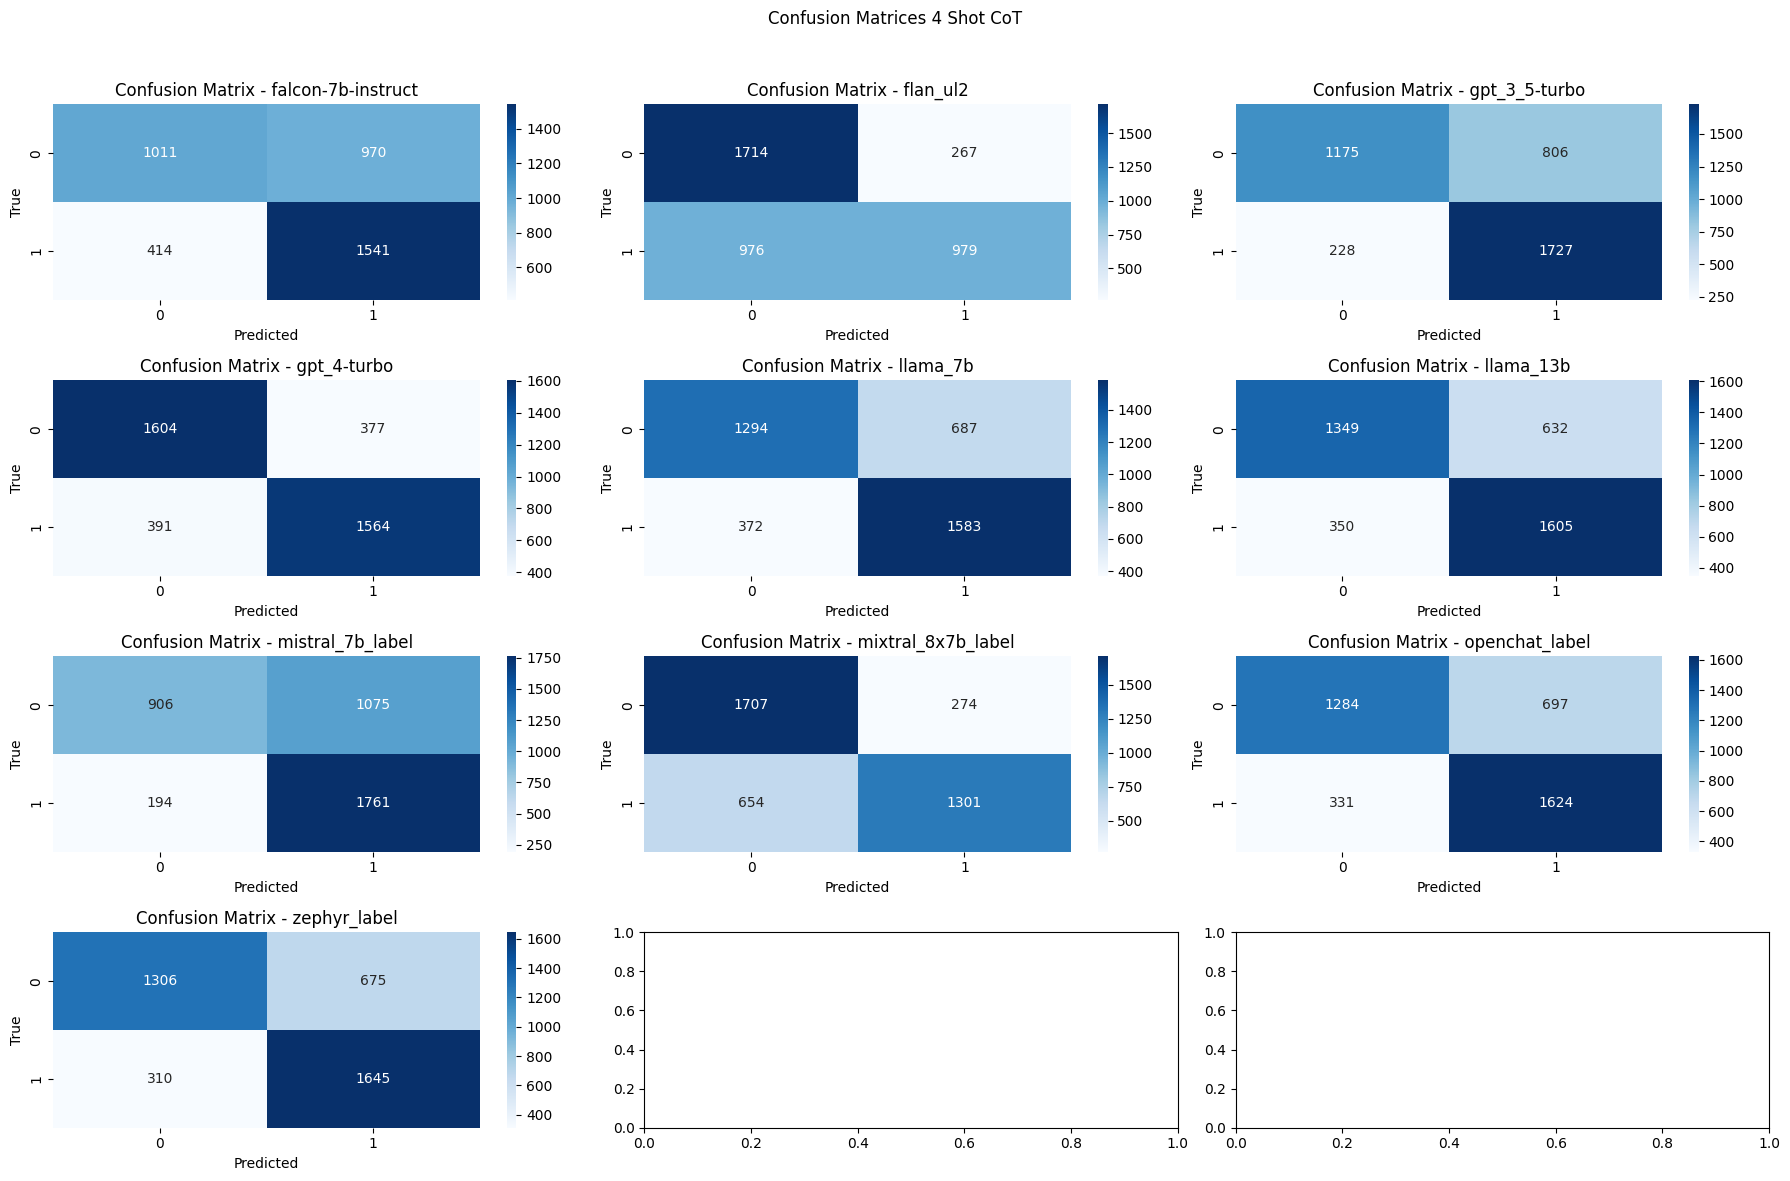

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, df, true_labels_column, predicted_labels_column,
                          title=None
                          ):
    predicted_labels = df[f'{predicted_labels_column}'].astype(int)
    true_labels = df[f'{true_labels_column}'].astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)


    # Display confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True,
                yticklabels=True, ax=ax)

    title = title if title else predicted_labels_column

    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices 4 Shot CoT')


#df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
#df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
#df_openai_gpt_3_5_turbo = pd.read_csv('/homeanonymousPycharmProjects/Annomatic_Benchmark/4-shot-CoT/data/gpt-3.5-turbo.csv')
#df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
#df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
#df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
#df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
#df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
#df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
#df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")


# Plot each confusion matrix
plot_confusion_matrix(axes[0, 0], df_merge_all_runs, 'label', 'falcon_7b_label', 'falcon-7b-instruct')
plot_confusion_matrix(axes[0, 1], df_merge_all_runs, 'label', 'flan_ul2_label', 'flan_ul2')
plot_confusion_matrix(axes[0, 2], df_merge_all_runs, 'label', 'gpt_3_5_label', 'gpt_3_5-turbo')
plot_confusion_matrix(axes[1, 0], df_merge_all_runs, 'label', 'gpt_4_label', 'gpt_4-turbo')
plot_confusion_matrix(axes[1, 1], df_merge_all_runs, 'label', 'llama_7b_label', 'llama_7b')
plot_confusion_matrix(axes[1, 2], df_merge_all_runs, 'label', 'llama_13b_label', 'llama_13b')
plot_confusion_matrix(axes[2, 0], df_merge_all_runs, 'label', 'mistral_7b_label', 'mistral_7b_label')
plot_confusion_matrix(axes[2, 1], df_merge_all_runs, 'label', 'mixtral_8x7b_label', 'mixtral_8x7b_label')
plot_confusion_matrix(axes[2, 2], df_merge_all_runs, 'label', 'openchat_label', 'openchat_label')
plot_confusion_matrix(axes[3, 0], df_merge_all_runs, 'label', 'zephyr_label', 'zephyr_label')




plt.tight_layout(
    rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
plt.show()

# Krippendorff Alpha in 4-shot CoT

In [54]:
from krippendorff import alpha
import numpy as np

runs = ['falcon_7b_label', 'flan_ul2_label',
       'gpt_3_5_label', 'gpt_4_label', 'llama_7b_label', 'llama_13b_label',
       'mistral_7b_label', 'mixtral_8x7b_label', 'openchat_label',
       'zephyr_label']


def compute_krippendorff_alpha(dataframe, columns, missing_data='?'):
    """
    Compute Krippendorff's alpha for inter-rater reliability.

    Parameters:
    - dataframe: pd.DataFrame, the DataFrame containing the data.
    - columns: list, the list of column names to calculate alpha for.

    Returns:
    - alpha_value: float, Krippendorff's alpha value.
    """
    # Extract the relevant columns from the DataFrame
    data_subset = dataframe[columns]
    data_subset = data_subset.replace(missing_data, np.nan)

    # Ensure that the data is in a format suitable for krippendorff
    data_list = np.array([data_subset[col].tolist() for col in columns])

    # Calculate Krippendorff's alpha
    alpha_value = alpha(reliability_data=data_list)

    return alpha_value

In [55]:
alpha_value_with_errors = compute_krippendorff_alpha(df_merge_all_runs_with_errors, runs)
alpha_value_without_errors = compute_krippendorff_alpha(df_merge_all_runs, runs)

print(f"Krippendorff's Alpha (all runs with invalid data): {alpha_value_with_errors}")
print(f"Krippendorff's Alpha (all runs without invalid data): {alpha_value_without_errors}")

Krippendorff's Alpha (all runs with invalid data): 0.4705467871139931
Krippendorff's Alpha (all runs without invalid data): 0.47464260457823537


In [56]:
import itertools

def compute_krippendorff_alpha_for_k_runs(df, runs, k=None):
    # Initialize variables to store the best combination and alpha
    if k is None:
        k = len(runs)

    best_combination = None
    best_alpha = 0  # Assuming alpha ranges from 0 to 1

    # Iterate through all possible combinations
    for combination in itertools.combinations(runs, k):

        alpha_value = compute_krippendorff_alpha(df, list(combination))

        # Print alpha for the current combination
        print(f"Combination: {combination}, Alpha: {alpha_value}")

        # Update best combination and alpha if a higher alpha is found
        if alpha_value > best_alpha:
            best_alpha = alpha_value
            best_combination = combination

    # Print the best combination and alpha
    print(f"\nBest Combination: {best_combination}, Best Alpha: {best_alpha}")
    return best_alpha, best_combination

In [57]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs, runs, 3)

Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.24616381940646914
Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_4_label'), Alpha: 0.29391557263897683
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_7b_label'), Alpha: 0.29379121290868715
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_13b_label'), Alpha: 0.27326664469767326
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mistral_7b_label'), Alpha: 0.2132671872707318
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mixtral_8x7b_label'), Alpha: 0.2850155192442335
Combination: ('falcon_7b_label', 'flan_ul2_label', 'openchat_label'), Alpha: 0.31992756182426596
Combination: ('falcon_7b_label', 'flan_ul2_label', 'zephyr_label'), Alpha: 0.3053566589898318
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'gpt_4_label'), Alpha: 0.40980166765339854
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: 0.4220269568551829
Combination: ('falcon_7b_label', 'gpt_

(0.651563087825646, ('gpt_4_label', 'llama_13b_label', 'mixtral_8x7b_label'))

In [58]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs_with_errors, runs, 3)

Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.2400686941424396
Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_4_label'), Alpha: 0.287532995398164
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_7b_label'), Alpha: 0.28904505852289963
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_13b_label'), Alpha: 0.2686508834697767
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mistral_7b_label'), Alpha: 0.2077723219103973
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mixtral_8x7b_label'), Alpha: 0.2783907167902441
Combination: ('falcon_7b_label', 'flan_ul2_label', 'openchat_label'), Alpha: 0.3115359993411102
Combination: ('falcon_7b_label', 'flan_ul2_label', 'zephyr_label'), Alpha: 0.3010207373150129
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'gpt_4_label'), Alpha: 0.4066217845180411
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: 0.4178902426325106
Combination: ('falcon_7b_label', 'gpt_3_5_la

(0.6473883973435703, ('gpt_4_label', 'llama_13b_label', 'mixtral_8x7b_label'))

In [59]:
df_merge_all_runs.shape

(3936, 18)

In [60]:
df_merge_all_runs.query("gpt_4_label != mixtral_8x7b_label").shape

(548, 18)